# Introduction

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns

## Env

In [2]:
env = gym.make('Taxi-v3')

## Constants

In [3]:
num_states = env.observation_space.n
num_actions = env.action_space.n  # number of actions
num_options = 4 # red green blue yellow

GAMMA = 0.9
ALPHA = 0.99
EPSILON = 0.1
NUM_EPISODES = 5000
actions = ["south", "north", "east", "west", "pickup", "dropoff"]
color = ["red", "green", "blue", "yellow", "taxi"]
positions = env.unwrapped.locs

# Plot functions

In [4]:
def show_rewards(*reward_avgs_list, title = "SMDP Q-Learning"):
    plt.figure()
    for i, reward_avgs in enumerate(reward_avgs_list):
        reward_avgs = np.array(reward_avgs)

    # Calculate mean and standard deviation
        reward_mean = np.mean(reward_avgs, axis=0)
        reward_std = np.std(reward_avgs, axis = 0)

    # Plotting rewards
        if i % 2 == 0:
            plt.plot(reward_mean, label=title, color='blue')
        else:
            plt.plot(reward_mean, label='Type 2', color='red')
            
        plt.fill_between(range(len(reward_mean)), reward_mean - reward_std, reward_mean + reward_std, alpha=0.25)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
    plt.show()

def plot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.axhline(y=max(y) if ylabel=='Steps' else min(y), color='r', linestyle='-.')
    plt.text(len(x)//2, max(y) + 3, "Max Value: " + str(max(y)), color='r' if ylabel=='Steps' else 'g')
    
    plt.axhline(y=min(y) if ylabel=='Steps' else max(y), color='g', linestyle='-.')
    plt.text(len(x)//2, min(y) - 20, "Min Value: " + str(min(y)), color='g' if ylabel=='Steps' else 'r')
    plt.show()

ACTION_NAMES = [u"\u2193", u"\u2191", u"\u2192", u"\u2190", 'PICKUP', 'DROPOFF', 'R', 'G', 'Y', 'B']
LOCATIONS = ['RED (0, 0)', 'GREEN (0, 4)', 'YELLOW (4, 0)', 'BLUE (4, 3)']

def plot_heatmap(values, title, ax, primitive=True):
    if primitive:
        actions = np.argmax(values, axis=1)
    else:
        actions = np.argmax(values[:, 4:], axis=1) + 4
    sns.heatmap(np.max(values, axis=1).reshape(5, 5), annot=np.array([ACTION_NAMES[action] for action in actions]).reshape(5, 5), fmt='', cmap="YlGnBu", ax=ax)
    # sns.heatmap(np.max(values, axis=1).reshape(5, 5), annot=np.round(np.max(values, axis = 1).reshape(5, 5), 1), fmt='', cmap="YlGnBu", ax=ax)
    ax.set_title(title)

def visualize_Q(q_values, start, dest, primitive=True):
    def state_encoder(taxi_row, taxi_col, passenger_location, destination ):
        return ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
    pre_pickup_q_values = np.array([q_values[state_encoder(i, j, start, dest)] for i in range(5) for j in range(5)])
    post_pickup_q_values = np.array([q_values[state_encoder(i, j, 4, dest)] for i in range(5) for j in range(5)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    plot_heatmap(pre_pickup_q_values, "Pre-Pickup", ax1, primitive)
    plot_heatmap(post_pickup_q_values, "Post-Pickup", ax2, primitive)

    fig.suptitle("Q-values Heatmap for pickup at {} and dropoff at {}".format(LOCATIONS[start], LOCATIONS[dest]))
    plt.show()

## Options

In [5]:
def epsilon_greedy(Q, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(Q.shape[1])
    else:
        return np.argmax(Q[state])

In [6]:
class Option:
    def __init__(self, option_id):
        self.option_id = option_id
        self.policy = np.zeros((num_states, num_actions))
        self.color = color[option_id]
    
    def get_action(self, env, state, learnOption=True):
        optact = None
        optdone = False
        x, y, pos, dest = env.unwrapped.decode(state)
        if (x,y) == positions[self.option_id]:
            optdone = True
            optact = 0
        else:
            if learnOption:
                state_action = self.policy[state]
                state_action = state_action - np.max(state_action)
                exp = np.exp(state_action)
                probs = exp / np.sum(exp)
                optact = np.random.choice(num_actions, p=probs)
            else:
                optact = np.argmax(self.policy[state])
        return optact, optdone
    
    def update_policy(self, env, state, action, next_state):
        x_next, y_next, _, _ = env.unwrapped.decode(next_state)
        reward = 0
        if (x_next, y_next) == positions[self.option_id]:
            reward = 20
        else:
            reward = -4
        self.policy[state][action] += ALPHA * (reward + GAMMA * np.max(self.policy[next_state]) - self.policy[state][action])
    
    def eligible(self, env, state):
        x, y, _, _ = env.unwrapped.decode(state)
        return not ((x, y) == positions[self.option_id])


## SMDP

In [7]:
def trainSMDP(n_episodes=NUM_EPISODES, printEvery=False, options=None, learnOptions = True):
    # count = {}
    if options is None:
        options = [Option(i) for i in range(num_options)]
    Q_SMDP = np.zeros((num_states, num_actions + num_options))
    fre_SMDP = np.zeros((num_states, num_actions + num_options))
    reward_scores = []
    # decay = 0.99999
    epsilon = EPSILON
    for i_episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        score = 0
        steps = 0
        while not done:
            # action = epsilon_greedy(Q_SMDP[:, 4:], state, epsilon) + 4  # only consider options, pickup and dropoff
            eligible = [0, 1, 2, 3, 4, 5]
            # eligible = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            # # eligible = [4, 5]
            for i in range(num_options):
                if options[i].eligible(env, state):
                    eligible.append(num_actions + i)
            eligible = np.array(eligible)
            # if  not (eligible.shape[0] == num_actions + num_options):
            #     print(list(env.unwrapped.decode(state))) 
            eligible_action = epsilon_greedy(Q_SMDP[:, eligible], state, epsilon)
            action = eligible[eligible_action]
            # epsilon = max(epsilon * decay, 0.01)
            action = epsilon_greedy(Q_SMDP, state, epsilon)
            if action < num_actions:
                next_state, reward, done, trunc, _ = env.step(action)
                done = done or trunc
                score += reward
                steps += 1
                Q_SMDP[state][action] += ALPHA * (reward + GAMMA * np.max(Q_SMDP[next_state]) - Q_SMDP[state][action])
                fre_SMDP[state][action] += 1
                state = next_state
    
            else:
                option = options[action - num_actions]
                optdone = False
                tau = 0
                reward_bar = 0
                init_state = state
                init_action = action
                learnOption = learnOptions
                while not (optdone or done):
                    tau += 1
                    optact,optdone = option.get_action(env, state, learnOption)
                    next_state, reward, done, trunc, _ = env.step(optact)
                    done = done or trunc
                    reward_bar += reward * GAMMA ** tau
                    score += reward
                    steps += 1
                    fre_SMDP[state][action] += 1
                    if learnOption:
                        option.update_policy(env, state, optact, next_state)
                    optact,optdone = option.get_action(env, next_state, learnOption)
                    state = next_state
                estimate = reward_bar + GAMMA**tau * np.max(Q_SMDP[state])
                # x, y, pos, dest = env.unwrapped.decode(init_state)
                # count[(pos, dest)] = count.get((pos, dest), 0) + 1
                Q_SMDP[init_state][init_action] += ALPHA * (estimate - Q_SMDP[init_state][init_action])
        reward_scores.append(score)
        if printEvery and (i_episode + 1) % 100 == 0:
            print(f"Episode {i_episode + 1}, Current Score {score}, Average Score: {sum(reward_scores[-100:])/len(reward_scores[-100:])}, Steps: {steps}, Epsilon {epsilon}")
    # print(count)
    return reward_scores, Q_SMDP, options
    

In [8]:
all_rewards = []
for _ in range(5):
    reward_scores, Q_SMDP, options = trainSMDP(n_episodes=1000, printEvery=False)
    # reward_scores, _, _ = trainSMDP(printEvery=False, options=options, learnOptions=False)
    all_rewards.append(reward_scores)

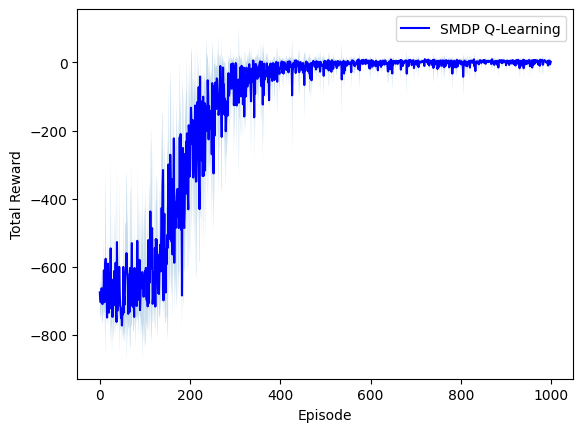

In [9]:
show_rewards(all_rewards[:1000])

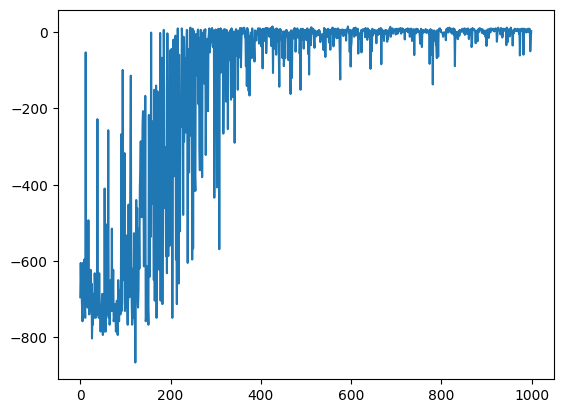

In [10]:
plt.plot([i for i in range(len(all_rewards[3]))], all_rewards[3])

Episode 100, Current Score -731, Average Score: -676.63, Steps: 200, Epsilon 0.1
Episode 200, Current Score -36, Average Score: -462.71, Steps: 48, Epsilon 0.1
Episode 300, Current Score -14, Average Score: -130.43, Steps: 26, Epsilon 0.1
Episode 400, Current Score 0, Average Score: -35.07, Steps: 12, Epsilon 0.1
Episode 500, Current Score 8, Average Score: -10.66, Steps: 13, Epsilon 0.1
Episode 600, Current Score 1, Average Score: -6.74, Steps: 20, Epsilon 0.1
Episode 700, Current Score -3, Average Score: -2.61, Steps: 24, Epsilon 0.1
Episode 800, Current Score 5, Average Score: -2.89, Steps: 16, Epsilon 0.1
Episode 900, Current Score -3, Average Score: -1.29, Steps: 15, Epsilon 0.1
Episode 1000, Current Score 5, Average Score: 3.31, Steps: 16, Epsilon 0.1


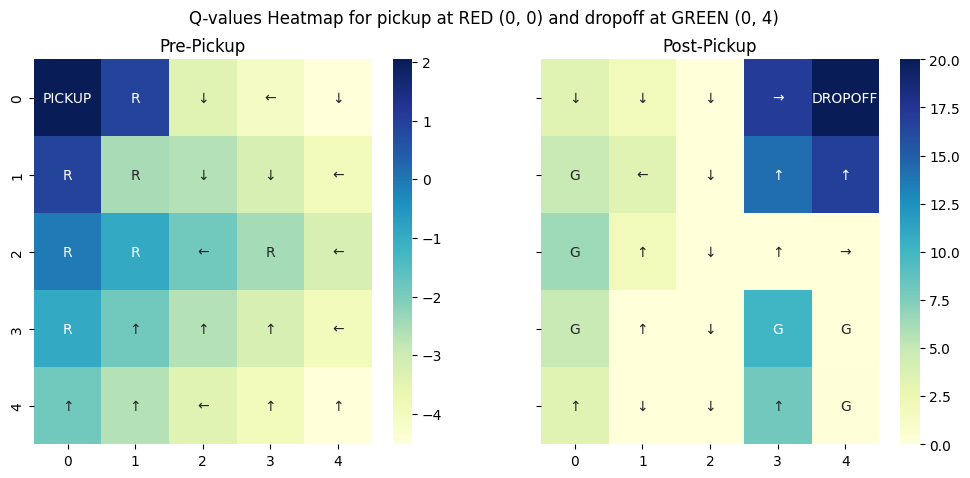

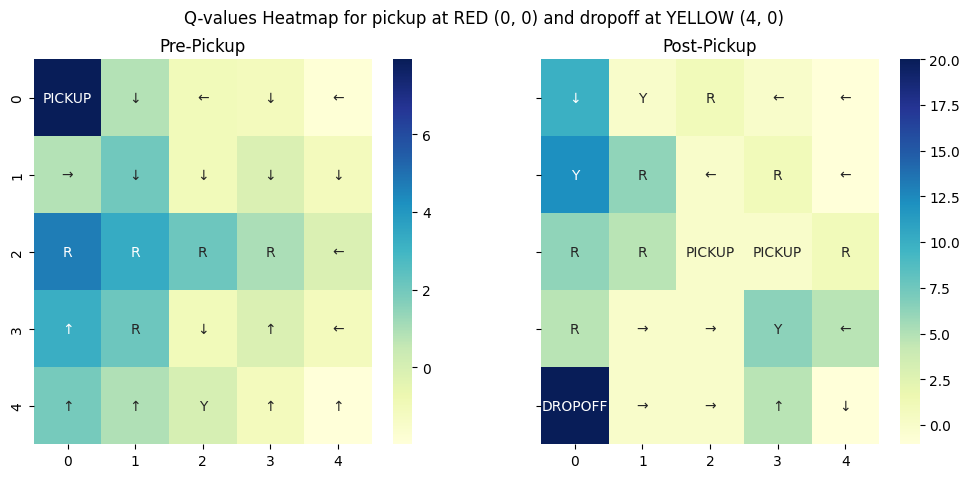

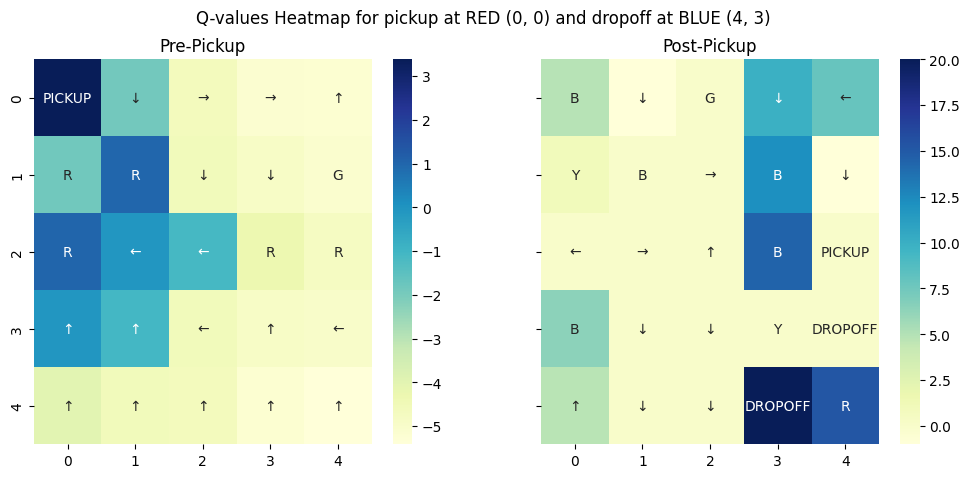

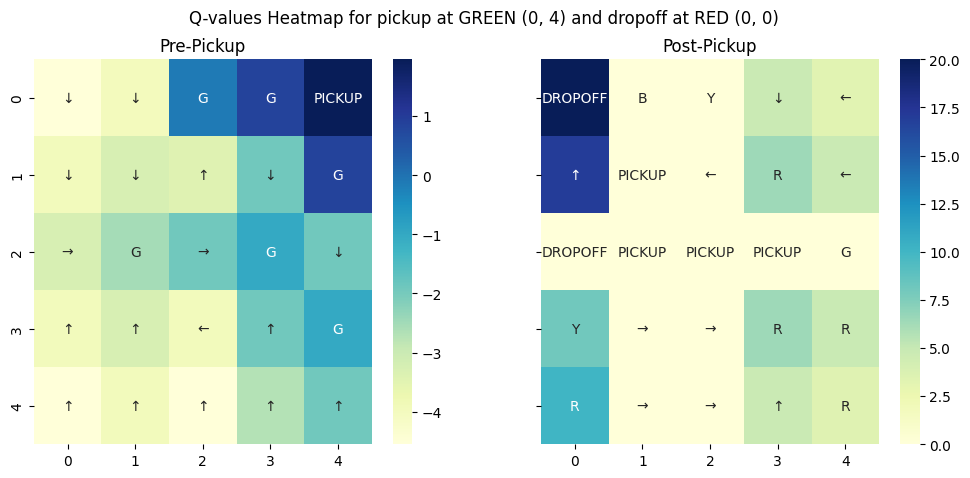

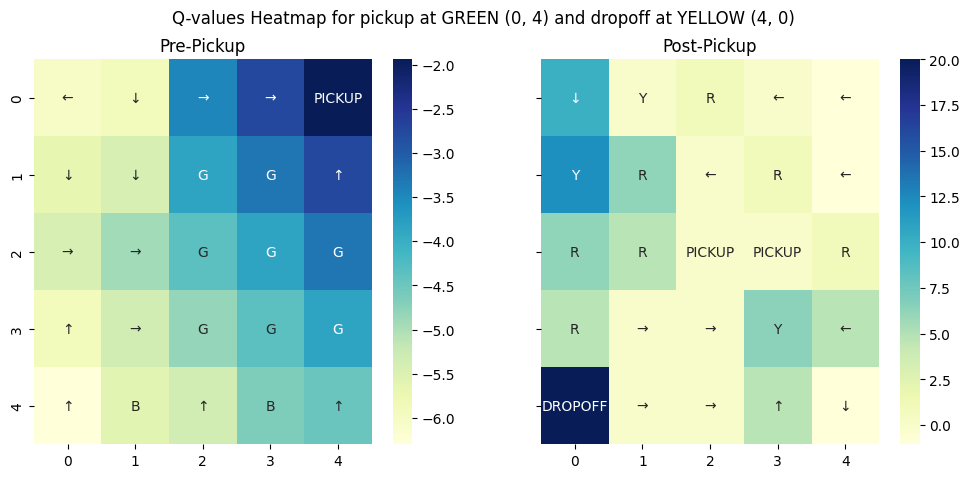

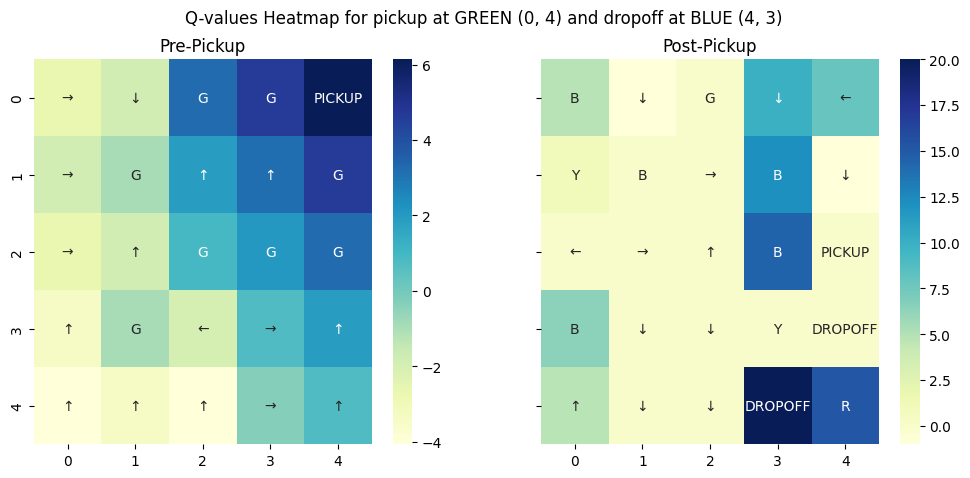

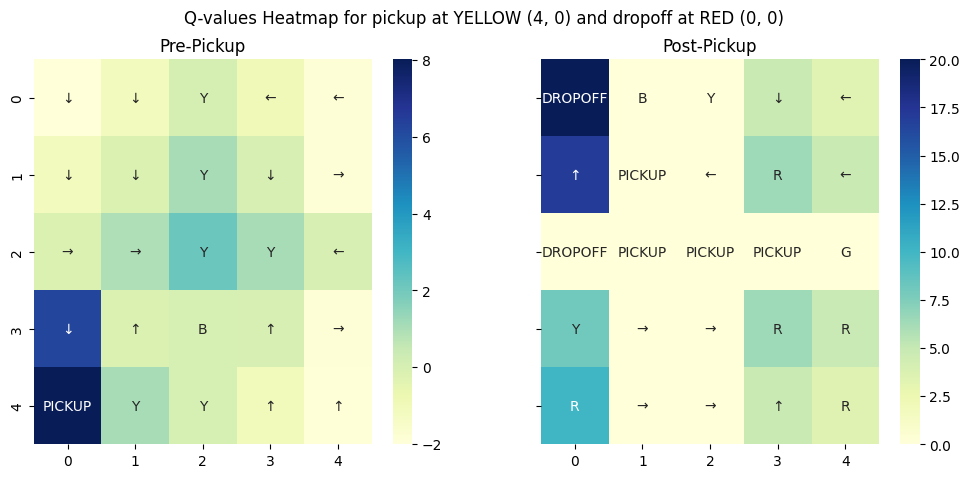

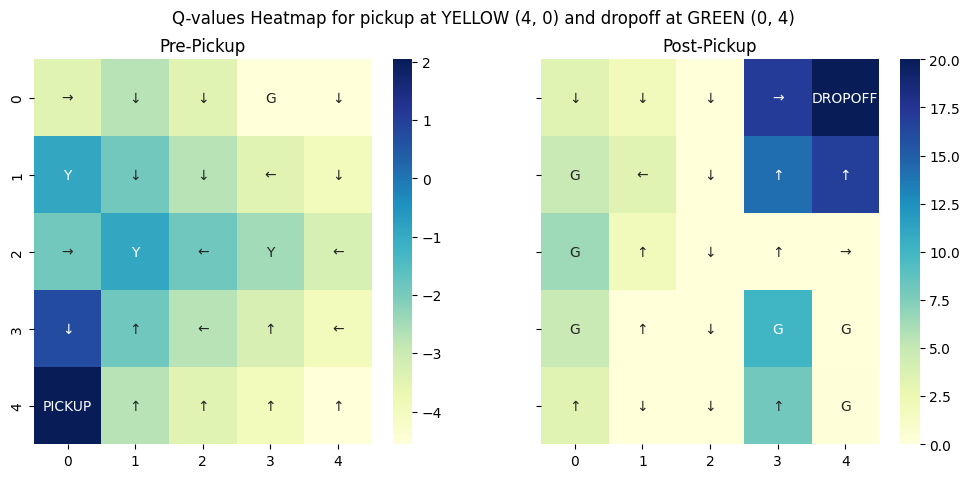

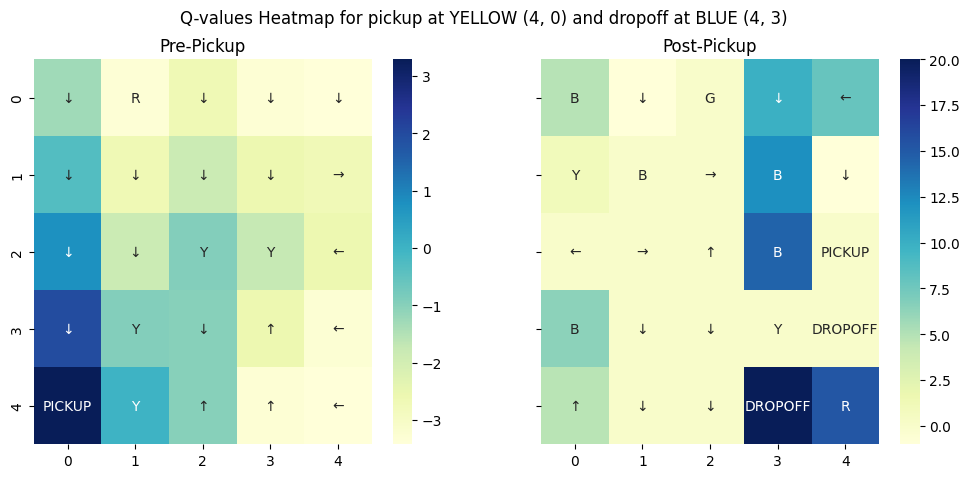

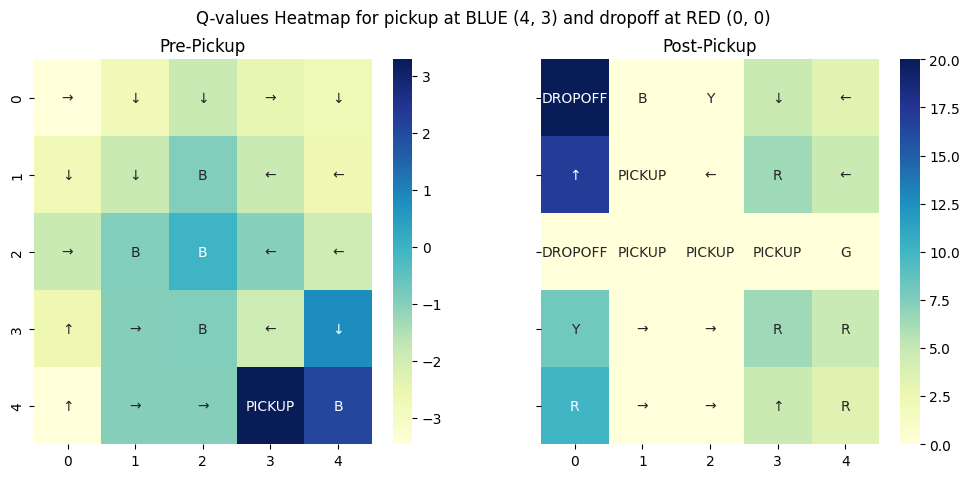

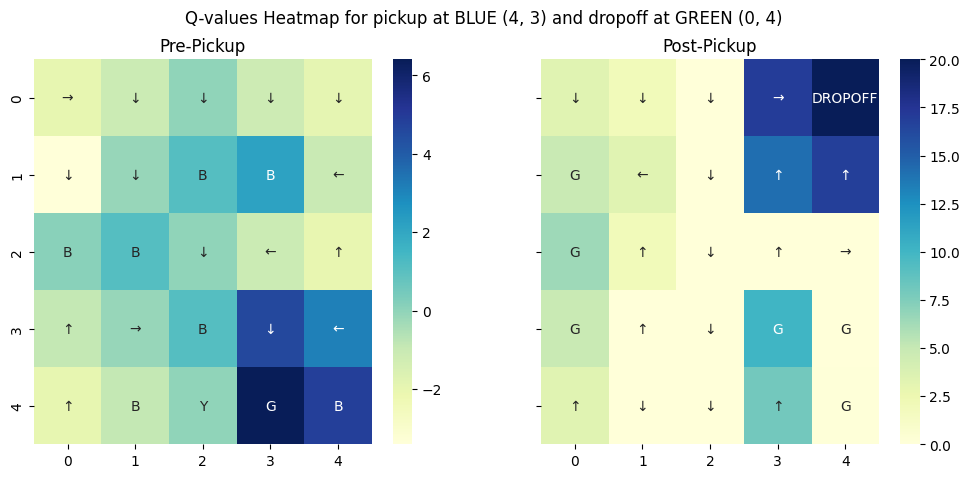

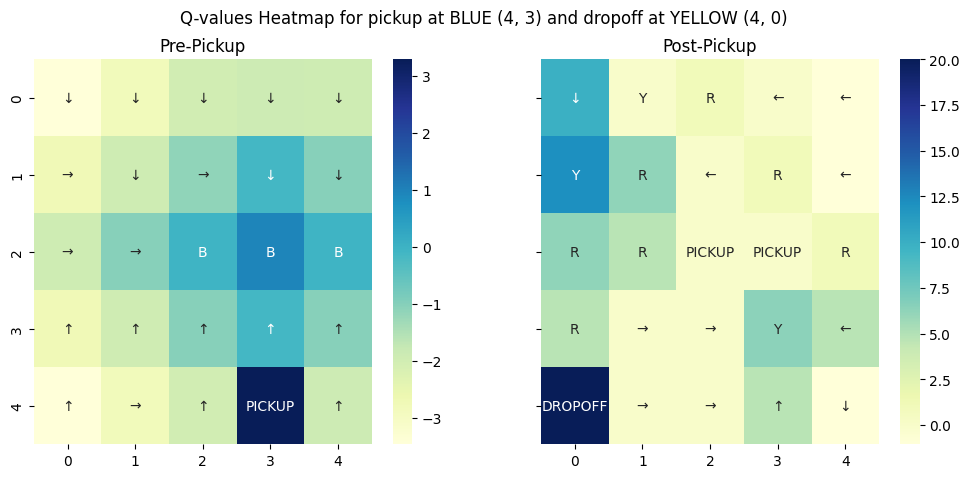

In [11]:
_, Q_SMDP, options = trainSMDP(n_episodes=1000, printEvery=True)
# _, Q_SMDP, _ = trainSMDP(printEvery=True, options=options, learnOptions=False)
NUM_STARTS = 4
NUM_DESTS = 4

for i in range(NUM_STARTS):
    for j in range(NUM_DESTS):
        if i != j:
            visualize_Q(Q_SMDP, i, j)

In [12]:
def state_encoder(taxi_row, taxi_col, passenger_location, destination ):
    return ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
Q_SMDP[state_encoder(0, 0, 3, 2)]

array([ -3.46460097,  -4.06222202,  -4.06229367,  -4.06222202,
        -9.9       , -11.683881  ,  -4.46904464, -38.71120993,
       -24.1461    , -32.62168811])

# Intra Option Learning

In [13]:
def update_opt_q_values(Q_IO, env, options, option_id, state, action, reward, next_state):
    optact, optdone = options[option_id].get_action(env, state)
    if optact == action:
        action_id = num_actions + option_id
        _, optdone = options[option_id].get_action(env, next_state)

        if optdone:
            estimate_value = reward + GAMMA * np.max(Q_IO[next_state, :])
        else:
            estimate_value = reward + GAMMA * Q_IO[next_state, action_id]  
              
        Q_IO[state, action_id] += ALPHA * (estimate_value - Q_IO[state, action_id])

def update_q_values(Q_IO, env, options, state, action, reward, next_state, update_primitive=False):
    if update_primitive:
        estimate_value = reward + GAMMA * np.max(Q_IO[next_state, :])
        Q_IO[state, action] += ALPHA * (estimate_value - Q_IO[state, action])

    for option_id in range(num_options):
        update_opt_q_values(Q_IO, env, options, option_id, state, action, reward, next_state)

In [14]:
def trainIntra(n_episodes = NUM_EPISODES, printEvery=False):
    options = [Option(i) for i in range(num_options)]
    reward_scores = []
    Q_IO = np.zeros((num_states, num_actions + num_options))
    # fre_IO = np.zeros((num_states, num_actions + num_options))
    
    for i_episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        score = 0
    
        while not done:
            action = epsilon_greedy(Q_IO, state, EPSILON)
            eligible = [0, 1, 2, 3, 4, 5]
            # eligible = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            # # eligible = [4, 5]
            for i in range(num_options):
                if options[i].eligible(env, state):
                    eligible.append(num_actions + i)
            # eligible = np.array(eligible)
            # if  not (eligible.shape[0] == num_actions + num_options):
            #     print(list(env.unwrapped.decode(state))) 
            eligible_action = epsilon_greedy(Q_IO[:, eligible], state, EPSILON)
            action = eligible[eligible_action]
            # action = epsilon_greedy(Q_IO[:, 4:], state, EPSILON) + 4
    
            if action < num_actions:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                update_q_values(Q_IO, env, options,  state, action, reward, next_state, True)
    
                score += reward
                state = next_state
    
            else:
                option_id = action - num_actions
                option = options[option_id]
                optdone = False 
    
                while not (optdone or done):
                    optact, optdone = option.get_action(env, state)
                    if not optdone:
                        next_state, reward, terminated, truncated, _ = env.step(optact)
                        update_q_values(Q_IO, env, options, state, optact, reward, next_state, True)
                        done = terminated or truncated
    
                    option.update_policy(env, state, optact, next_state)
                    score += reward
                    state = next_state    
        reward_scores.append(score)
    
        if printEvery and (i_episode + 1) % 100 == 0:
            print("Episode: {}, Score: {}, Average Score: {}".format(i_episode + 1, score, sum(reward_scores[-100:])/100))
    return reward_scores, Q_IO 

In [15]:
all_rewards_IO = []
for _ in range(5):
    reward_scores, Q_IO = trainIntra(n_episodes=1000)
    all_rewards_IO.append(reward_scores)

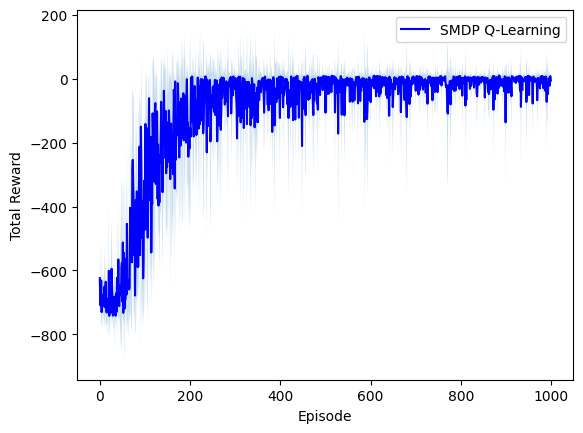

In [16]:
show_rewards(all_rewards_IO[:1000])

Episode: 100, Score: 8, Average Score: -561.64
Episode: 200, Score: -45, Average Score: -197.89
Episode: 300, Score: -24, Average Score: -90.96
Episode: 400, Score: 9, Average Score: -53.27
Episode: 500, Score: 9, Average Score: -29.21
Episode: 600, Score: -34, Average Score: -32.43
Episode: 700, Score: 11, Average Score: -25.75
Episode: 800, Score: 8, Average Score: -20.34
Episode: 900, Score: 9, Average Score: -18.45
Episode: 1000, Score: 3, Average Score: -12.29
Episode: 1100, Score: -8, Average Score: -14.83
Episode: 1200, Score: 4, Average Score: -15.84
Episode: 1300, Score: 8, Average Score: -4.3
Episode: 1400, Score: -21, Average Score: -3.59
Episode: 1500, Score: 11, Average Score: -7.41
Episode: 1600, Score: 1, Average Score: -8.02
Episode: 1700, Score: -27, Average Score: -9.06
Episode: 1800, Score: 8, Average Score: -12.55
Episode: 1900, Score: 8, Average Score: -7.49
Episode: 2000, Score: 0, Average Score: -3.91


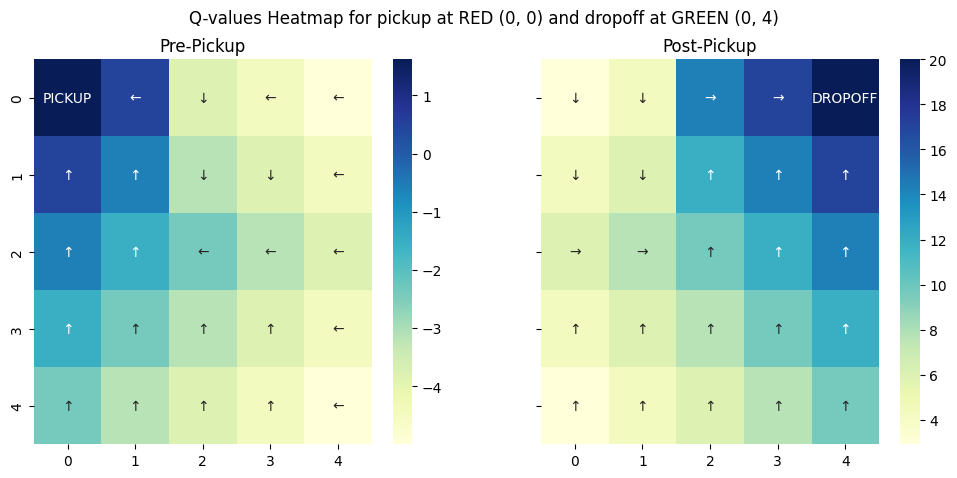

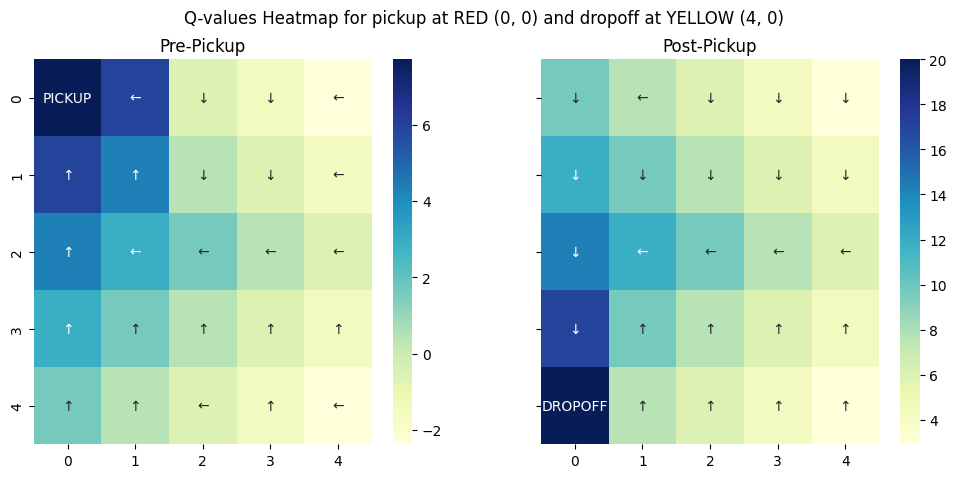

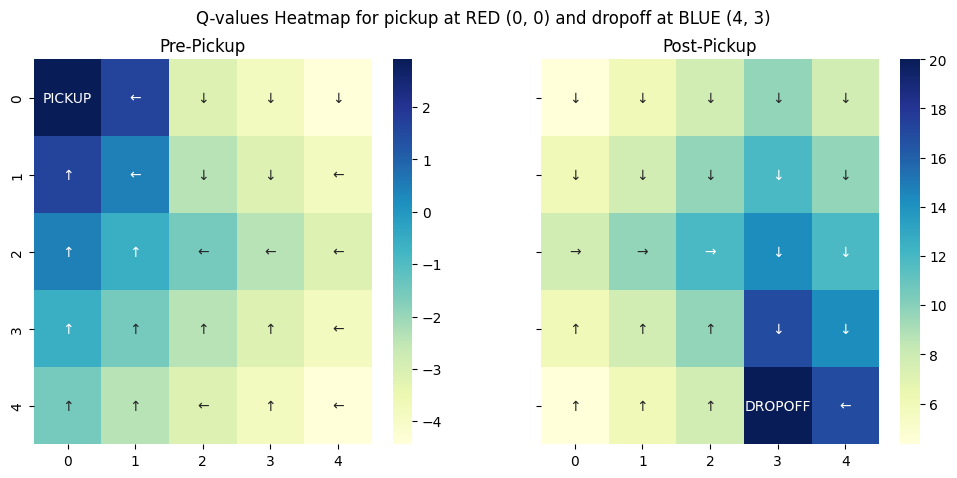

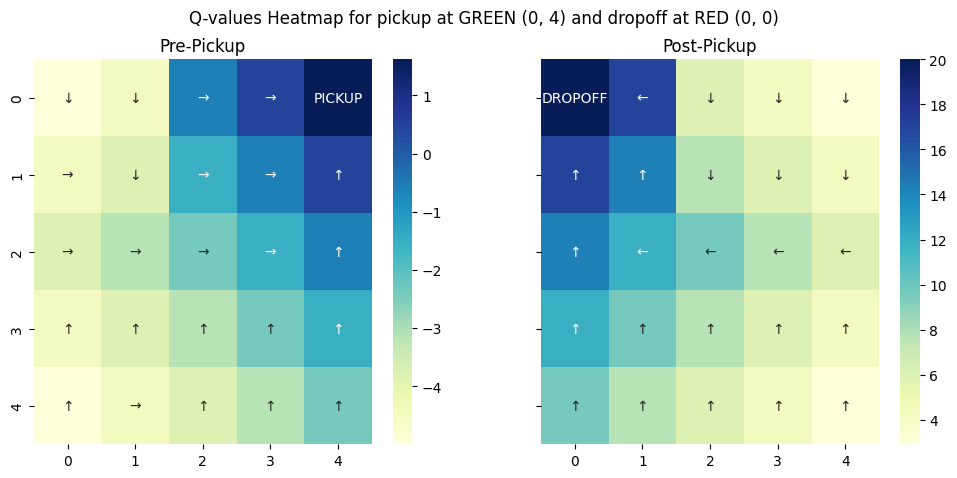

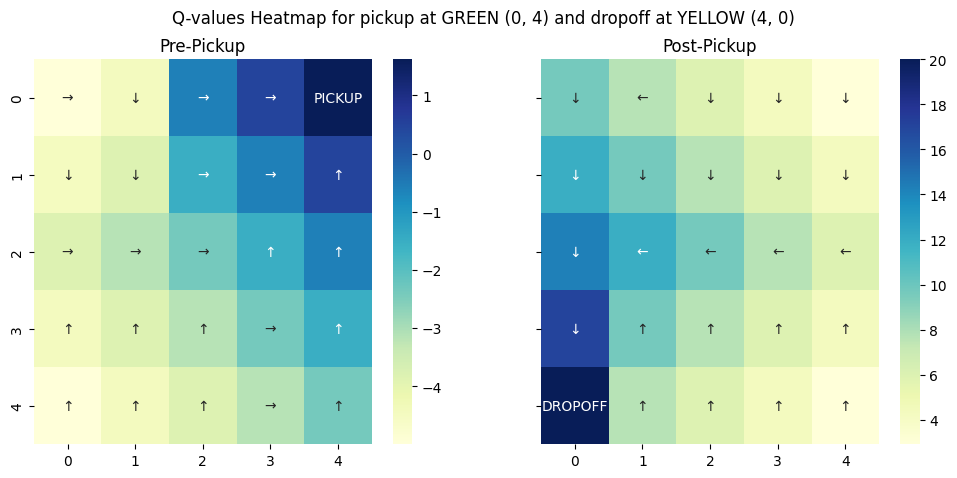

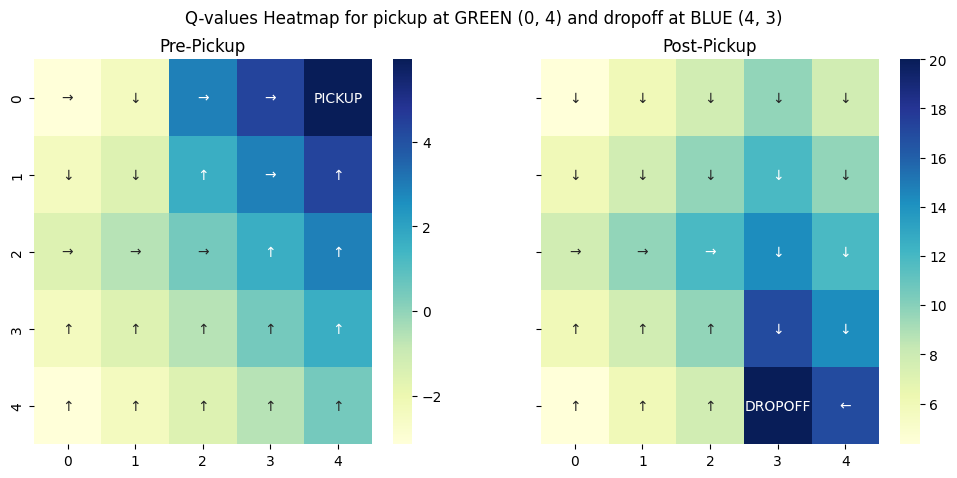

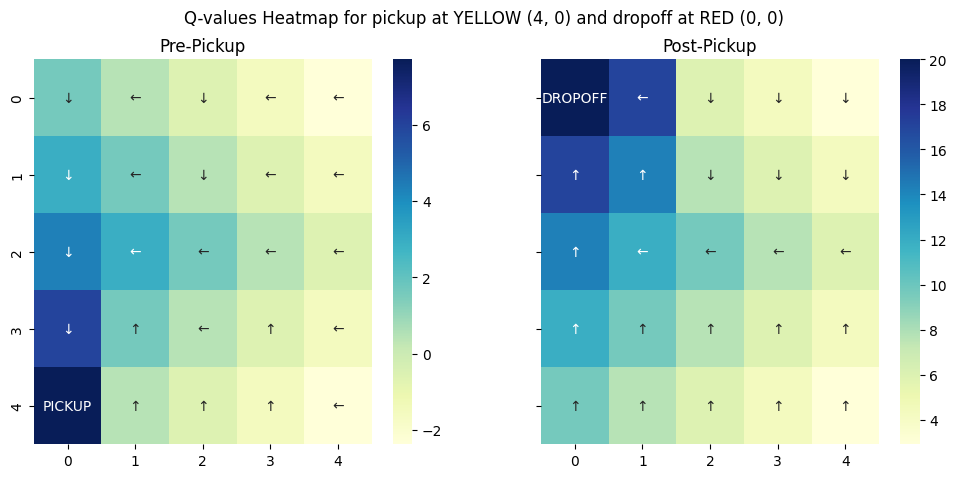

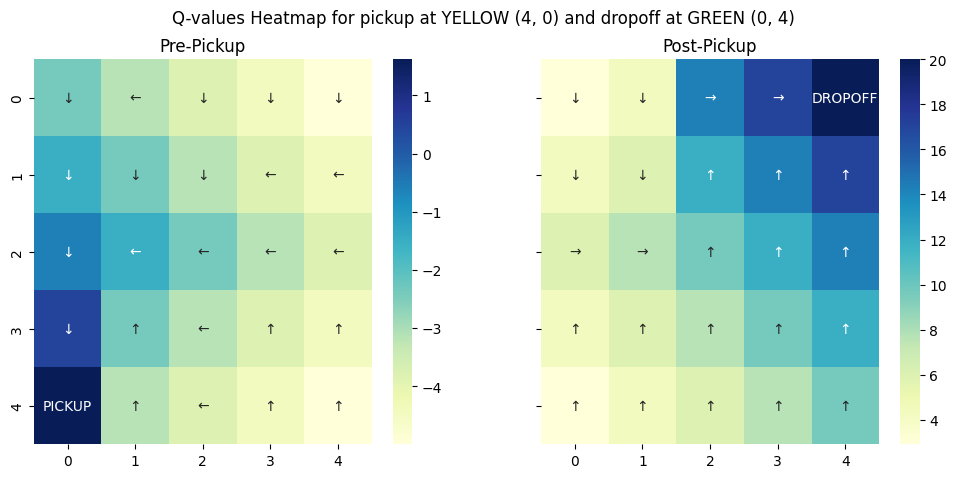

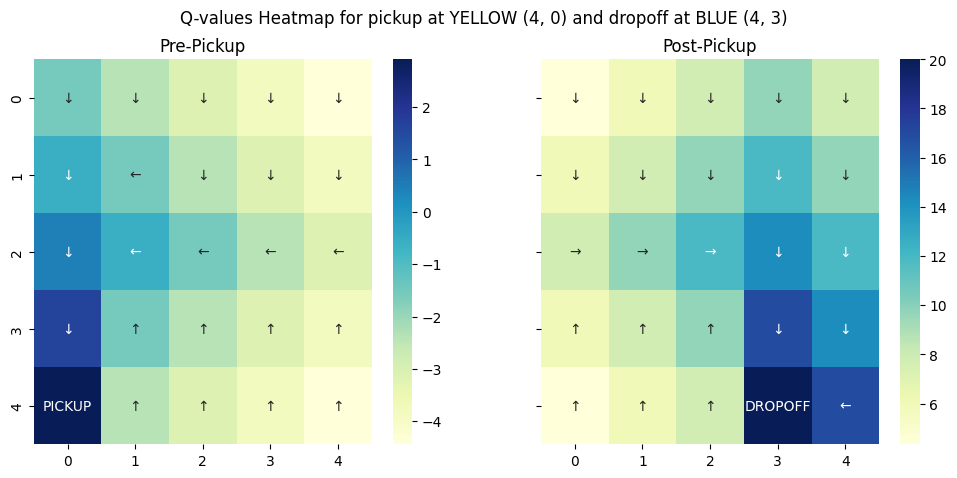

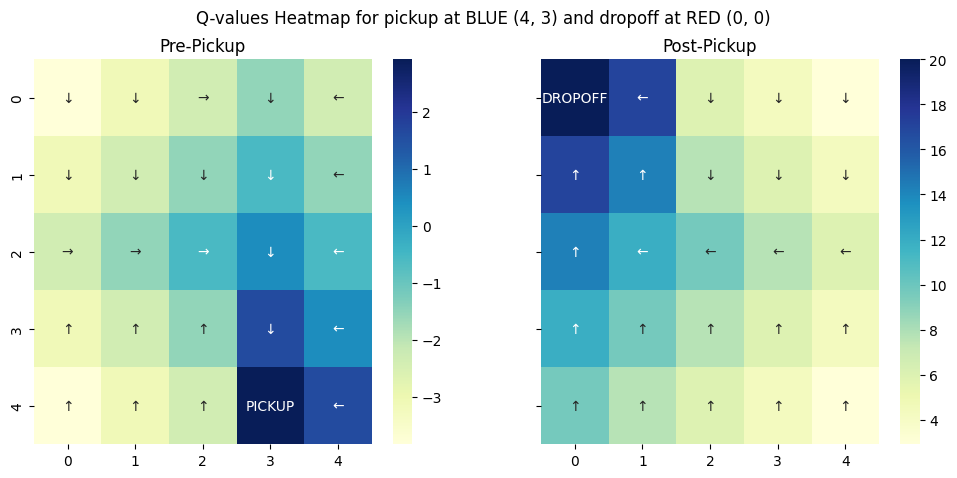

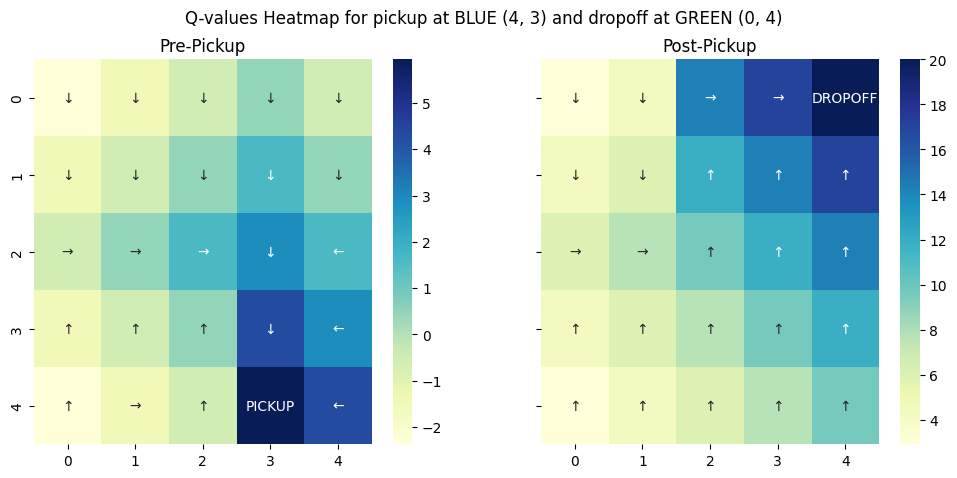

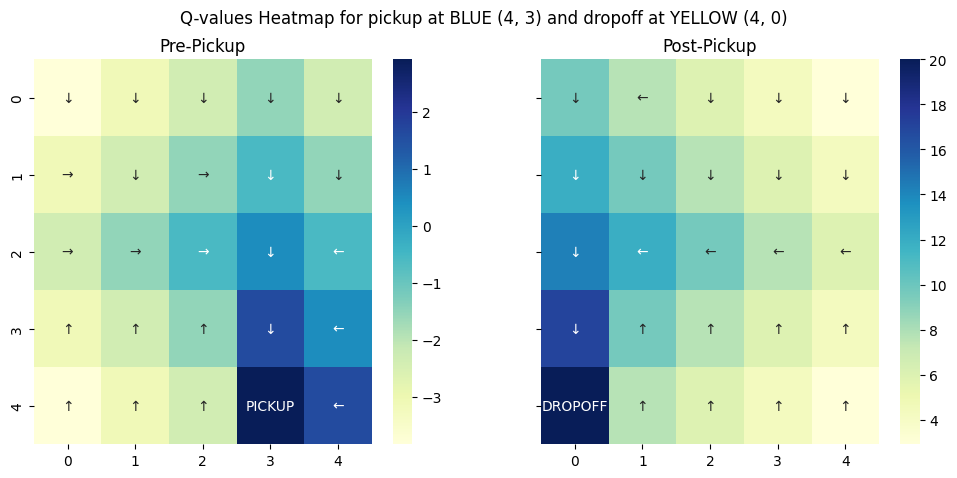

In [17]:
_, Q_IO = trainIntra(n_episodes=2000, printEvery=True)
NUM_STARTS = 4
NUM_DESTS = 4

for i in range(NUM_STARTS):
    for j in range(NUM_DESTS):
        if i != j:
            visualize_Q(Q_IO, i, j)

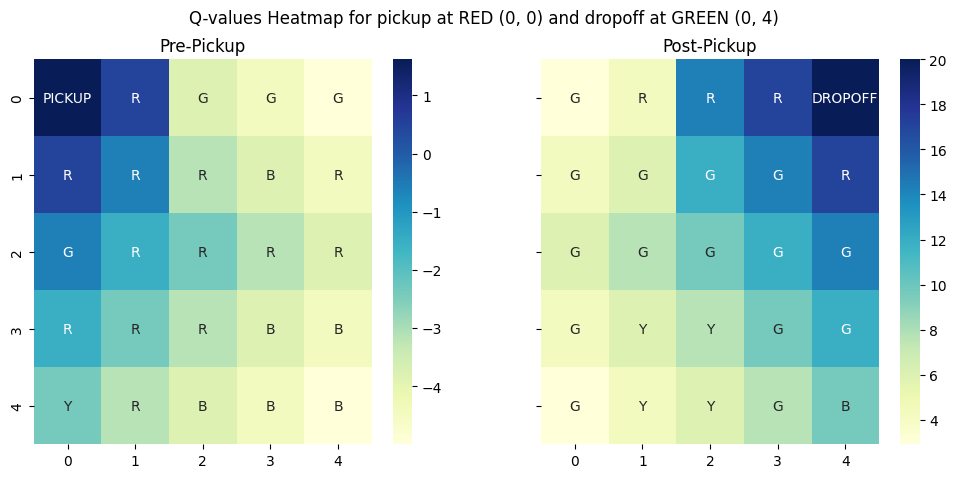

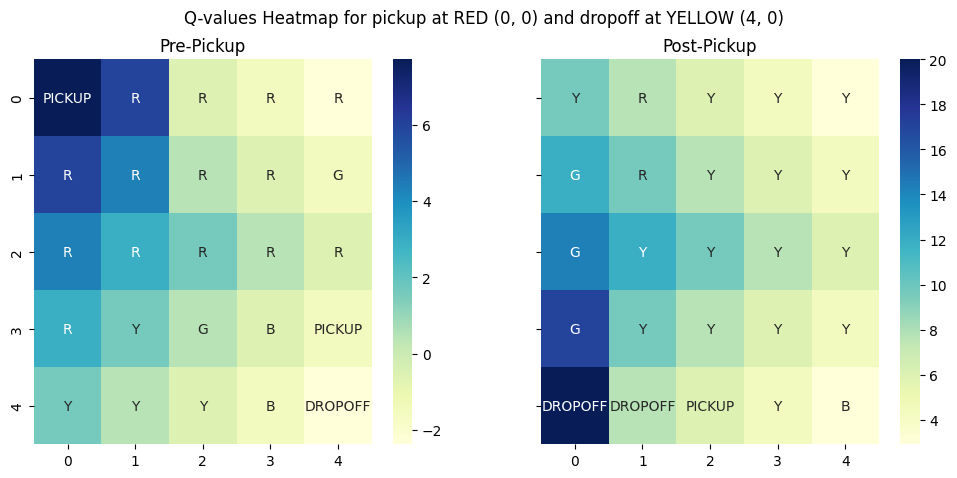

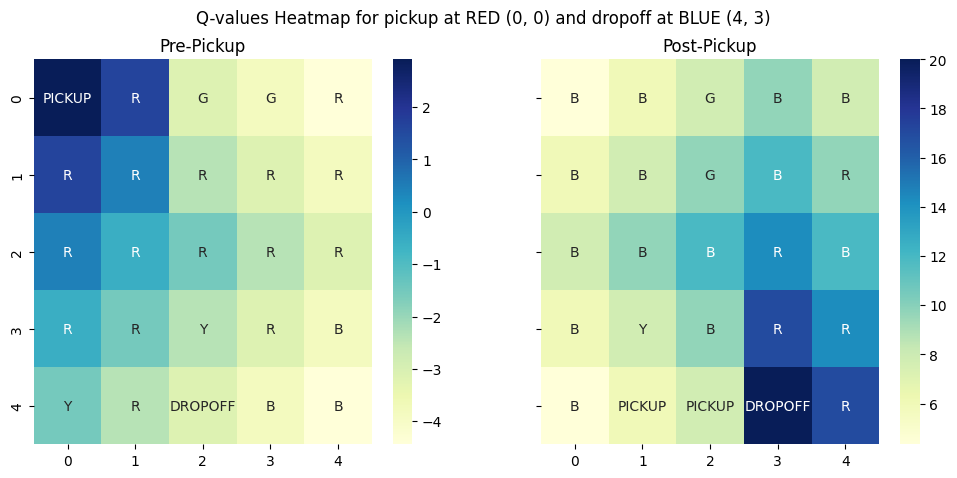

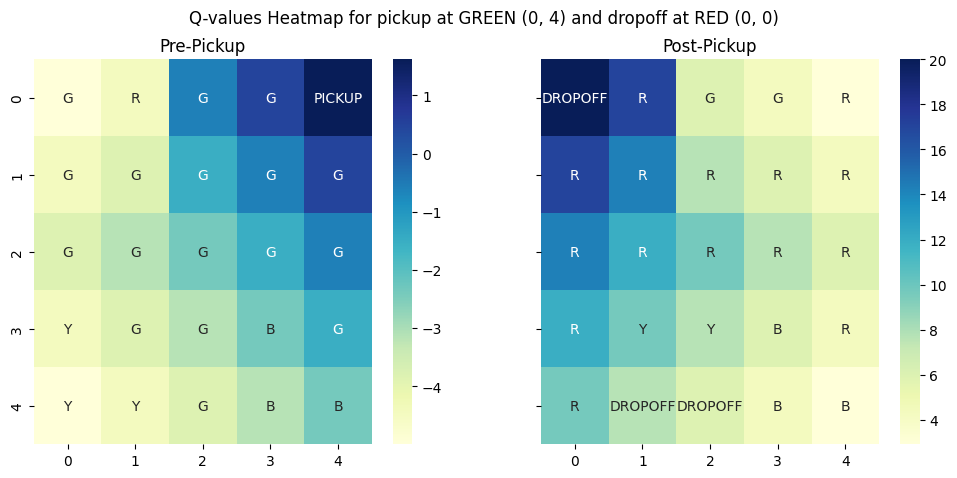

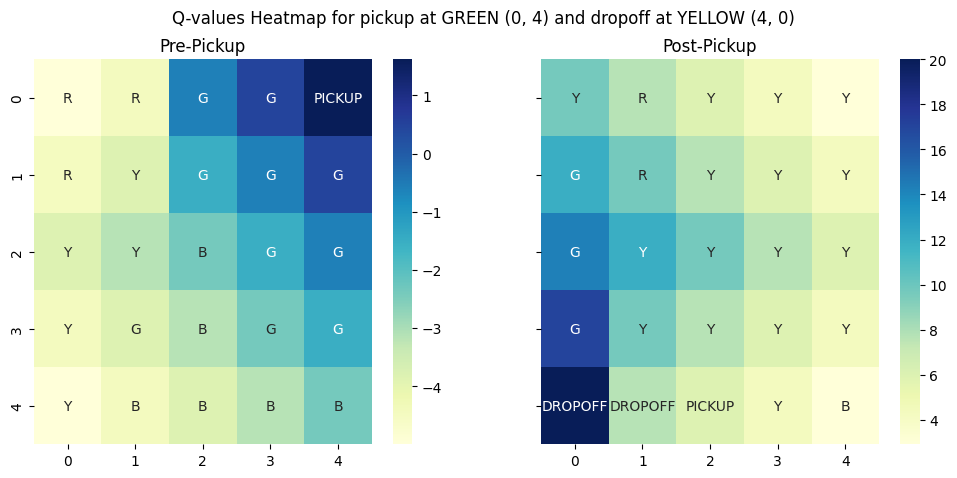

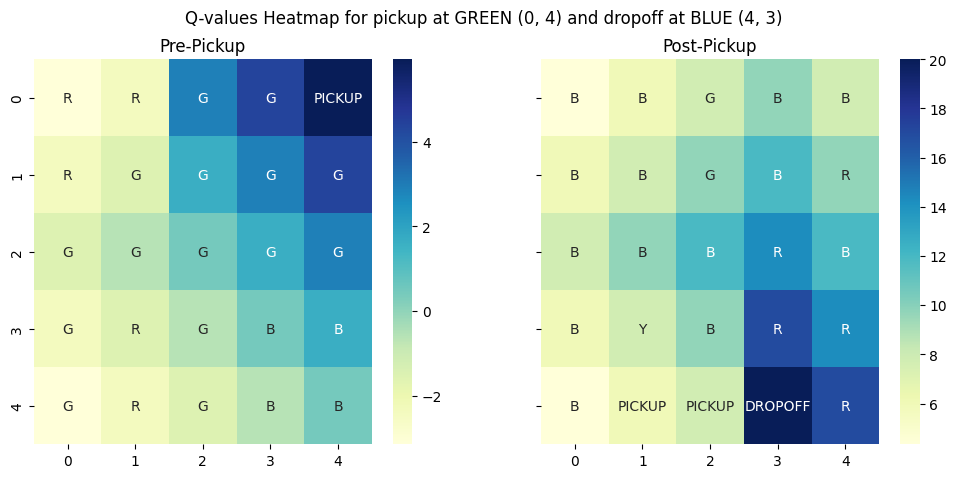

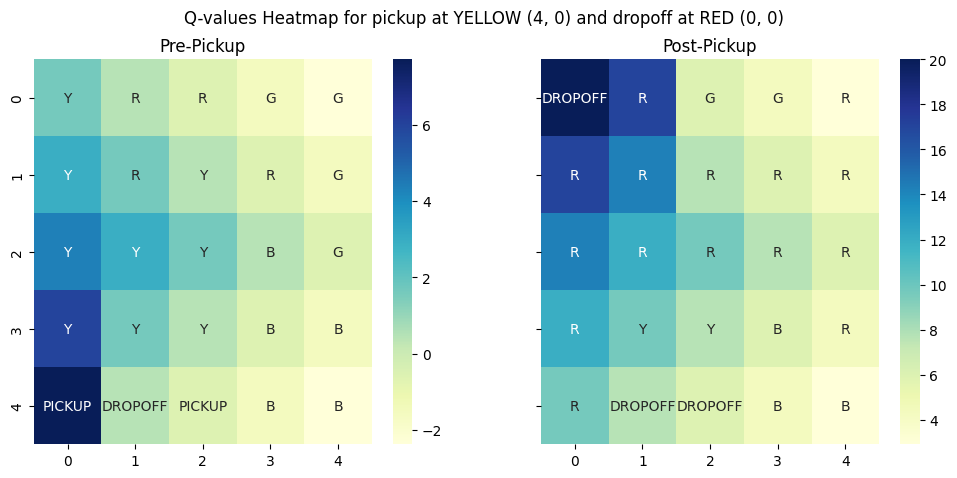

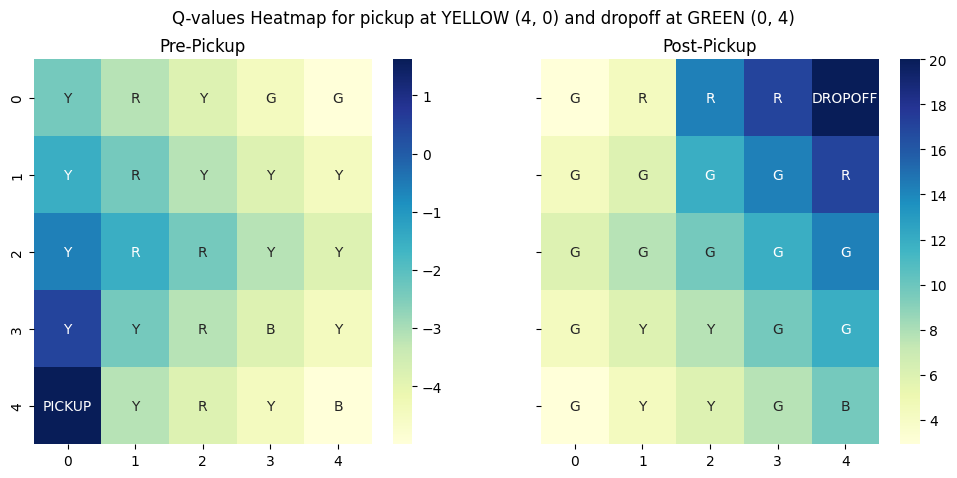

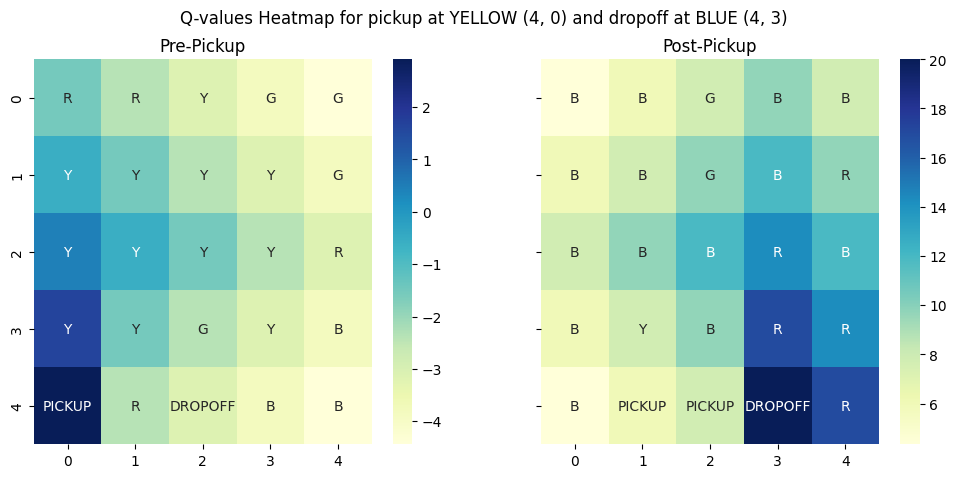

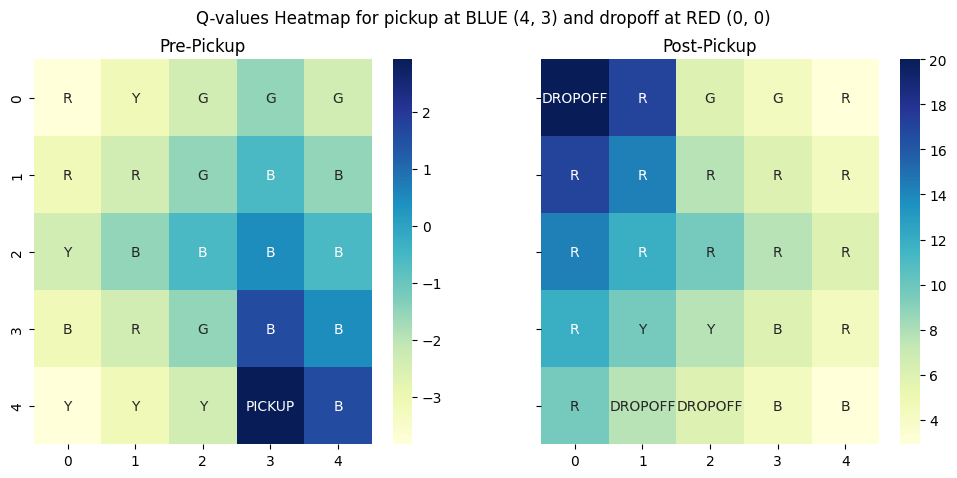

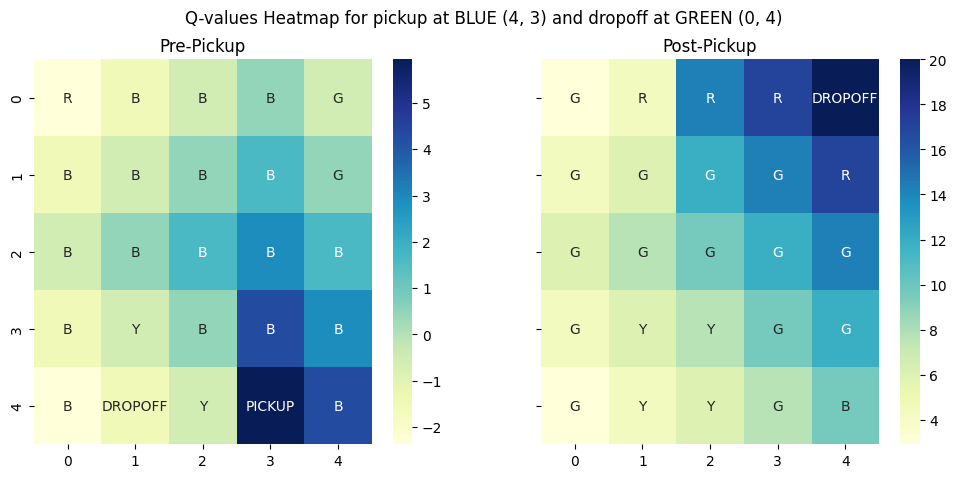

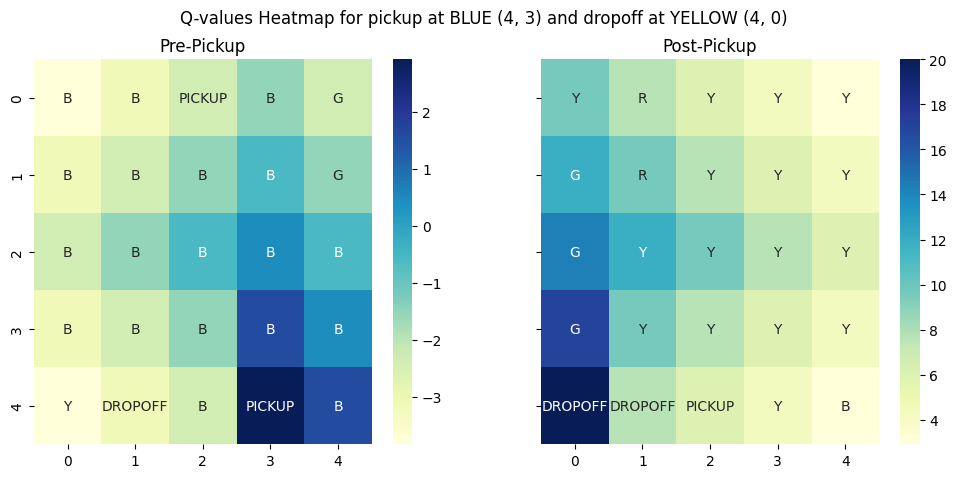

In [18]:
NUM_STARTS = 4
NUM_DESTS = 4

for i in range(NUM_STARTS):
    for j in range(NUM_DESTS):
        if i != j:
            visualize_Q(Q_IO, i, j, primitive=False)